## 9. Stable Diffusion DDIM
- Reproduce Stable diffusion results in Figure 9.29
- Our approach here is to copy and take appart sections of the diffusers library so we can do things like remove noise during image generation
- We found this setup a nice way to experiment step-by-step with a high quality pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from diffusers import (
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler,
    LMSDiscreteScheduler,
)
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import (
    retrieve_timesteps,
)

In [2]:
# model_id = "stabilityai/stable-diffusion-2"
model_id = "sd2-community/stable-diffusion-2-1"
# model_id = "runwayml/stable-diffusion-v1-5"

# Use the Euler scheduler here instead
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler") #Woah so different!
# scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, scheduler=scheduler, torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [3]:
prompt = "A lone tree standing in the middle of a desert, under the harsh light of midday, casting a long shadow on the sand."
height = None
width = None
num_inference_steps = 50
timesteps = None
sigmas = None
guidance_scale = 7.5
negative_prompt = None
num_images_per_prompt = 1
eta = 0.0
generator = None
latents = None
prompt_embeds = None
negative_prompt_embeds = None
ip_adapter_image = None
ip_adapter_image_embeds = None
output_type = "pil"
return_dict = True
cross_attention_kwargs = None
guidance_rescale = 0.0
clip_skip = None
callback_on_step_end = None
callback_on_step_end_tensor_inputs = ["latents"]

In [4]:
generator = torch.Generator(device="cuda").manual_seed(11)

In [5]:
if not height or not width:
    height = (
        pipe.unet.config.sample_size
        if pipe._is_unet_config_sample_size_int
        else pipe.unet.config.sample_size[0]
    )
    width = (
        pipe.unet.config.sample_size
        if pipe._is_unet_config_sample_size_int
        else pipe.unet.config.sample_size[1]
    )
    height, width = height * pipe.vae_scale_factor, width * pipe.vae_scale_factor

In [6]:
pipe._guidance_scale = guidance_scale
pipe._guidance_rescale = guidance_rescale
pipe._clip_skip = clip_skip
pipe._cross_attention_kwargs = cross_attention_kwargs
pipe._interrupt = False

In [7]:
# 2. Define call parameters
if prompt is not None and isinstance(prompt, str):
    batch_size = 1
elif prompt is not None and isinstance(prompt, list):
    batch_size = len(prompt)
else:
    batch_size = prompt_embeds.shape[0]

device = pipe._execution_device

In [8]:
# 3. Encode input prompt
lora_scale = (
    pipe.cross_attention_kwargs.get("scale", None)
    if pipe.cross_attention_kwargs is not None
    else None
)

prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
    prompt,
    device,
    num_images_per_prompt,
    pipe.do_classifier_free_guidance,
    negative_prompt,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    lora_scale=lora_scale,
    clip_skip=pipe.clip_skip,
)

In [9]:
# For classifier free guidance, we need to do two forward passes.
# Here we concatenate the unconditional and text embeddings into a single batch
# to avoid doing two forward passes
if pipe.do_classifier_free_guidance:
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
    image_embeds = self.prepare_ip_adapter_image_embeds(
        ip_adapter_image,
        ip_adapter_image_embeds,
        device,
        batch_size * num_images_per_prompt,
        pipe.do_classifier_free_guidance,
    )

In [10]:
# 4. Prepare timesteps
timesteps, num_inference_steps = retrieve_timesteps(
    pipe.scheduler, num_inference_steps, device, timesteps, sigmas
)

In [11]:
# 5. Prepare latent variables
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
    batch_size * num_images_per_prompt,
    num_channels_latents,
    height,
    width,
    prompt_embeds.dtype,
    device,
    generator,
    latents,
)

In [12]:
# 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)

# 6.1 Add image embeds for IP-Adapter
added_cond_kwargs = (
    {"image_embeds": image_embeds}
    if (ip_adapter_image is not None or ip_adapter_image_embeds is not None)
    else None
)

# 6.2 Optionally get Guidance Scale Embedding
timestep_cond = None
if pipe.unet.config.time_cond_proj_dim is not None:
    guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(
        batch_size * num_images_per_prompt
    )
    timestep_cond = self.get_guidance_scale_embedding(
        guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
    ).to(device=device, dtype=latents.dtype)

In [13]:
res = {
    "latent_model_input": [],
    "noise_pred_uncond": [],
    "noise_pred_text": [],
    "noise_pred": [],
    "latents": [],
}

# 7. Denoising loop
with torch.no_grad():
    num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
    pipe._num_timesteps = len(timesteps)
    with pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # if pipe.interrupt:
            #     continue

            res["latent_model_input"].append(latents.detach().cpu().numpy())
            # expand the latents if we are doing classifier free guidance
            latent_model_input = (
                torch.cat([latents] * 2)
                if pipe.do_classifier_free_guidance
                else latents
            )
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                timestep_cond=timestep_cond,
                cross_attention_kwargs=pipe.cross_attention_kwargs,
                added_cond_kwargs=added_cond_kwargs,
                return_dict=False,
            )[0]

            # perform guidance
            if pipe.do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + pipe.guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

            res["noise_pred_uncond"].append(noise_pred_uncond.detach().cpu().numpy())
            res["noise_pred_text"].append(noise_pred_text.detach().cpu().numpy())
            res["noise_pred"].append(noise_pred.detach().cpu().numpy())

            if (
                pipe.do_classifier_free_guidance and pipe.guidance_rescale > 0.0
            ):  # pipe.guidance_rescale=0.0
                # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                noise_pred = rescale_noise_cfg(
                    noise_pred, noise_pred_text, guidance_rescale=pipe.guidance_rescale
                )

            # compute the previous noisy sample x_t -> x_t-1
            # latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

            ## --- Scheduler override --- ##
            ## DDIM Scheduler
            # self,
            model_output = noise_pred
            timestep = t
            sample = latents
            eta = 0.0
            use_clipped_model_output = False
            generator = generator
            variance_noise = None
            return_dict = False

            # 1. get previous step value (=t-1)
            prev_timestep = (
                timestep
                - pipe.scheduler.config.num_train_timesteps
                // pipe.scheduler.num_inference_steps
            )

            # 2. compute alphas, betas
            alpha_prod_t = pipe.scheduler.alphas_cumprod[timestep]
            alpha_prod_t_prev = (
                pipe.scheduler.alphas_cumprod[prev_timestep]
                if prev_timestep >= 0
                else pipe.scheduler.final_alpha_cumprod
            )

            beta_prod_t = 1 - alpha_prod_t

            # 3. compute predicted original sample from predicted noise also called
            # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            if pipe.scheduler.config.prediction_type == "epsilon":
                pred_original_sample = (
                    sample - beta_prod_t ** (0.5) * model_output
                ) / alpha_prod_t ** (0.5)
                pred_epsilon = model_output
            elif pipe.scheduler.config.prediction_type == "sample":
                pred_original_sample = model_output
                pred_epsilon = (
                    sample - alpha_prod_t ** (0.5) * pred_original_sample
                ) / beta_prod_t ** (0.5)
            elif pipe.scheduler.config.prediction_type == "v_prediction":
                pred_original_sample = (alpha_prod_t**0.5) * sample - (
                    beta_prod_t**0.5
                ) * model_output
                pred_epsilon = (alpha_prod_t**0.5) * model_output + (
                    beta_prod_t**0.5
                ) * sample
            else:
                raise ValueError(
                    f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample`, or"
                    " `v_prediction`"
                )

            # 4. Clip or threshold "predicted x_0"
            if pipe.scheduler.config.thresholding:  # False
                pred_original_sample = self._threshold_sample(pred_original_sample)
            elif pipe.scheduler.config.clip_sample:  # False
                pred_original_sample = pred_original_sample.clamp(
                    -self.config.clip_sample_range, self.config.clip_sample_range
                )

            # 5. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            variance = pipe.scheduler._get_variance(timestep, prev_timestep)
            std_dev_t = eta * variance ** (0.5)

            if use_clipped_model_output:  # False
                # the pred_epsilon is always re-derived from the clipped x_0 in Glide
                pred_epsilon = (
                    sample - alpha_prod_t ** (0.5) * pred_original_sample
                ) / beta_prod_t ** (0.5)

            # SW - this might be a cleaner way to perturb things
            # alpha_prod_t_prev=1.01*alpha_prod_t_prev

            # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (
                0.5
            ) * pred_epsilon

            # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
            prev_sample = (
                alpha_prod_t_prev ** (0.5) * pred_original_sample
                + pred_sample_direction
            )

            ## 7 variant - SW Pertebation
            # prev_sample = 1.01*alpha_prod_t_prev ** (0.5) * pred_original_sample + 0.99*pred_sample_direction

            if eta > 0:
                if variance_noise is not None and generator is not None:
                    raise ValueError(
                        "Cannot pass both generator and variance_noise. Please make sure that either `generator` or"
                        " `variance_noise` stays `None`."
                    )

                if variance_noise is None:
                    variance_noise = randn_tensor(
                        model_output.shape,
                        generator=generator,
                        device=model_output.device,
                        dtype=model_output.dtype,
                    )
                variance = std_dev_t * variance_noise

                prev_sample = prev_sample + variance

            latents = prev_sample
            ### --- end scheduler hacking ---- ###

            res["latents"].append(latents.detach().cpu().numpy())

            # call the callback, if provided
            if i == len(timesteps) - 1 or (
                (i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0
            ):
                progress_bar.update()

            # if i == 35: break #Stop early to dig into scheduler

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
if not output_type == "latent":
    image = pipe.vae.decode(
        latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator
    )[
        0
    ].detach()  # Added .detach() to fix numpy() error
    image, has_nsfw_concept = pipe.run_safety_checker(
        image, device, prompt_embeds.dtype
    )
else:
    image = latents
    has_nsfw_concept = None

if has_nsfw_concept is None:
    do_denormalize = [True] * image.shape[0]
else:
    do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]
image = pipe.image_processor.postprocess(
    image.detach(), output_type=output_type, do_denormalize=do_denormalize
)

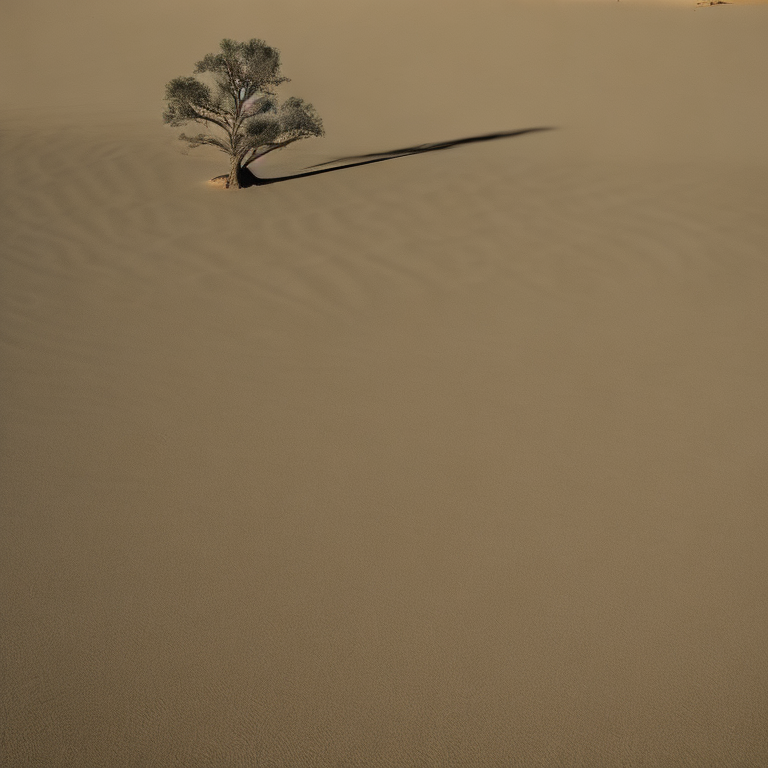

In [15]:
image[0]